# pyDynAA simulation engine

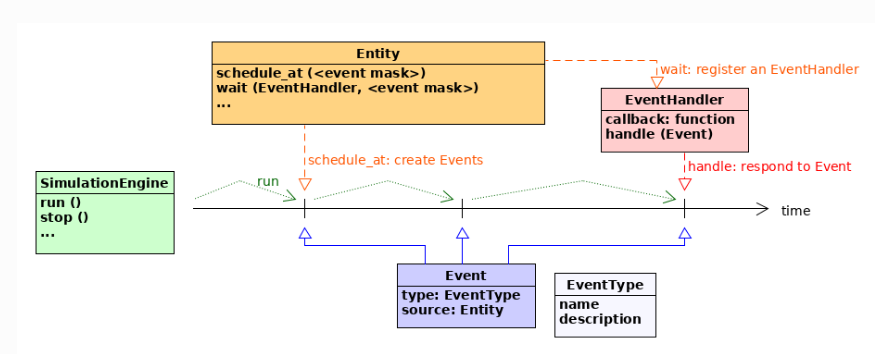

In [9]:
import netsquid as ns
import pydynaa
ns.set_random_state(seed=42) #ensure output is reproducible so fix seed to ns's ranodm number generator

## Ping Pong Example

ping pong example w/ discrete event simulation
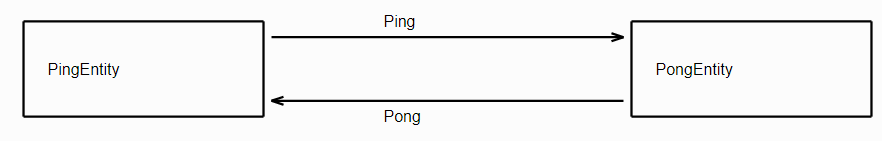

In [11]:
class PingEntity(pydynaa.Entity):
    ping_evtype = pydynaa.EventType("PING_EVENT", "A ping event.")
    delay = 10.

    #start() method of ping entity stars the game but the simulation is not yet run
    #qubit stars in |0> state
    def start(self, qubit):
        # Start the game by scheduling the first ping event after delay
        self.qubit = qubit
        #start() automatically stores qubit for later use
        #._schedule_after() immeditately schedules event after .ping_evtype happens
        self._schedule_after(self.delay, PingEntity.ping_evtype)

    def wait_for_pong(self, pong_entity):
        # Setup this entity to listen for pong events from a PongEntity
        pong_handler = pydynaa.EventHandler(self._handle_pong_event)
        self._wait(pong_handler, entity=pong_entity,
                   event_type=PongEntity.pong_evtype)

    def _handle_pong_event(self, event):
        # Callback function called by the pong handler when pong event is triggered
        m, prob = ns.qubits.measure(self.qubit, observable=ns.Z)
        labels_z = ("|0>", "|1>")
        print(f"{ns.sim_time():.1f}: Pong event! PingEntity measured "
              f"{labels_z[m]} with probability {prob:.2f}")
        self._schedule_after(PingEntity.delay, PingEntity.ping_evtype)

class PongEntity(pydynaa.Entity):
    pong_evtype = pydynaa.EventType("PONG_EVENT", "A pong event.")
    delay = 10.

    #to kep the game going pong entity set up to listen and respond to for ping events
    def wait_for_ping(self, ping_entity):
        # Setup this entity to listen for ping events from a PingEntity
        ping_handler = pydynaa.EventHandler(self._handle_ping_event)
        self._wait(ping_handler, entity=ping_entity, event_type=PingEntity.ping_evtype)
        #alternatively, if wanted to wiat for and handle only the first, could have used ._wait_once() method

    #pong entity accesses shared qubit by retrieving its source: the ping entity
    def _handle_ping_event(self, event):
        # Callback function called by the ping handler when ping event is triggered
        m, prob = ns.qubits.measure(event.source.qubit, observable=ns.X)
        labels_x = ("|+>", "|->")
        print(f"{ns.sim_time():.1f}: Ping event! PongEntity measured "
              f"{labels_x[m]} with probability {prob:.2f}")
        self._schedule_after(PongEntity.delay, PongEntity.pong_evtype)
        #pong entity measures qubit in Hadamard basis and prints result
        #schedules event of type pong_evtype to occur after a fixed delay using ._schedule_after()
        
    #ping entity also set up to listen and react to pong events, 
        #but ping entity measures qubit in standard basis

# Create entities and register them to each other
ping = PingEntity()
pong = PongEntity()
ping.wait_for_pong(pong)
pong.wait_for_ping(ping)
#
# Create a qubit and instruct the ping entity to start
qubit, = ns.qubits.create_qubits(1)
ping.start(qubit)

In [12]:
# running simulation: sim_run() method
# to limit run time to 90 nx, set end_time to 91 ns
stats = ns.sim_run(end_time=91)

10.0: Ping event! PongEntity measured |+> with probability 0.50
20.0: Pong event! PingEntity measured |1> with probability 0.50
30.0: Ping event! PongEntity measured |-> with probability 0.50
40.0: Pong event! PingEntity measured |1> with probability 0.50
50.0: Ping event! PongEntity measured |+> with probability 0.50
60.0: Pong event! PingEntity measured |0> with probability 0.50
70.0: Ping event! PongEntity measured |+> with probability 0.50
80.0: Pong event! PingEntity measured |1> with probability 0.50
90.0: Ping event! PongEntity measured |-> with probability 0.50


In [13]:
print(stats)


Simulation summary

Elapsed wallclock time: 0:00:00.011494
Elapsed simulation time: 9.10e+01 [ns]
Triggered events: 9
Handled callbacks: 9
Total quantum operations: 9
Frequent quantum operations: MEASURE = 9
Max qstate size: 1 qubits
Mean qstate size: 1.00 qubits



## Quantum Teleportation Example

A,B,C <br>
Charlie: continuaously generating an entangle pair of qubits |B<sub>00</sub>> (one for A, one for B) <br>
Alice: will wait for her entangled qubit to arrive, and once it does, she will entagle her own qubit with it, measure both and send classical corrections to Bob <br>
Bob: will wait for his entangled qubit from Charlie AND classical correction from Alice (EventExpression) <br>


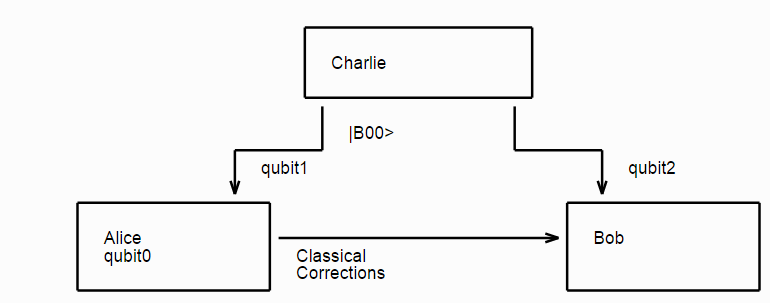

In [33]:
# reset simulation timeline, which efectively clears any events on the timeline and sets simulation time to 0
ns.sim_reset()

In [34]:
class Charlie(pydynaa.Entity):
    ready_evtype = pydynaa.EventType("QUBITS_READY", "Entangled qubits are ready.")
    _generate_evtype = pydynaa.EventType("GENERATE", "Generate entangled qubits.")
    period = 50.
    delay = 10.
    
    def __init__(self):
        # initiate Charlie by entangling qubits after every generation event
        self.entangled_qubits = None
        self._generate_handler = pydynaa.EventHandler(self._entangle_qubits)
        self._wait(self._generate_handler, entity=self,
                   event_type=Charlie._generate_evtype)
        
    def _entangle_qubits(self,event):
        #Callback function that entangled qubits and schedules and entanglement ready event
        q1, q2 = ns.qubits.create_qubits(2)
        ns.qubits.operate(q1, ns.H)
        ns.qubits.operate([q1, q2], ns.CNOT)
        self.entangled_qubits = [q1, q2]
        self._schedule_after(Charlie.delay, Charlie.ready_evtype)
        print(f"{ns.sim_time():.1f}: Charlie finished generating entanglement")
        self._schedule_after(Charlie.period, Charlie._generate_evtype)
        
    def start(self):
        #begin generating entanglement
        print(f"{ns.sim_time():.1f}: Charlie start generating entanglement")
        self._schedule_now(Charlie._generate_evtype)

In [35]:
class Alice(pydynaa.Entity):
    ready_evtype = pydynaa.EventType("CORRECTION_READY", "Corrections are ready.")
    _teleport_evtype = pydynaa.EventType("TELEPORT", "Teleport the qubit.")
    delay = 20.
    
    def __init__(self, teleport_state):
        #initialize Alice by setting teleport state and waiting to teleport
        self.teleport_state = teleport_state
        self.q0 = None
        self.q1 = None
        self.corrections = None
        self._teleport_handler = pydynaa.EventHandler(self._handle_teleport)
        self._wait(self._teleport_handler, entity=self, event_type=Alice._teleport_evtype)
        
    def wait_for_charlie(self,charlie):
        #setup Alice to wiat for an entangelement qubit from Charlie
        self._qubit_handler = pydynaa.EventHandler(self._handle_qubit)
        self._wait(self._qubit_handler, entity=charlie,
                   event_type=Charlie.ready_evtype)
        
    def _handle_qubit(self, event):
        #Callback fxn that handles arrival of entangled qubit and schedules teleportation
        self.q0, = ns.qubits.create_qubits(1, no_state=True)
        self.q1 = event.source.entangled_qubits[0]
        ns.qubits.assign_qstate([self.q0], self.teleport_state)
        self._schedule_after(Alice.delay, Alice._teleport_evtype)
        print(f"{ns.sim_time():.1f}: Alice received entangled qubit")
        
    def _handle_teleport(self,event):
        #Callback fxn that executes teleportation and schedules a corrections ready event
        ns.qubits.operate([self.q0, self.q1], ns.CNOT)
        ns.qubits.operate(self.q0, ns.H)
        m0, __ = ns.qubits.measure(self.q0)
        m1, __ = ns.qubits.measure(self.q1)
        self.corrections = [m0, m1]
        self._schedule_now(Alice.ready_evtype)
        print(f"{ns.sim_time():.1f}: Alice measured qubits & sending corrections")

In [36]:
class Bob(pydynaa.Entity):
    
    def wait_for_teleport(self, alice, charlie):
        # Setup Bob to wait for his entangled qubit and Alice's corrections
        charlie_ready_evexpr = pydynaa.EventExpression(
            source=charlie, event_type=Charlie.ready_evtype)
        alice_ready_evexpr = pydynaa.EventExpression(
            source=alice, event_type=Alice.ready_evtype)
        both_ready_evexpr = charlie_ready_evexpr & alice_ready_evexpr
        self._teleport_handler = pydynaa.ExpressionHandler(self._handle_teleport)
        self._wait(self._teleport_handler, expression=both_ready_evexpr)
        
    def _handle_teleport(self, event_expression):
        #Callback fxn that handles messages from both Alice and Charlie
        qubit = event_expression.first_term.atomic_source.entangled_qubits[1]
        alice = event_expression.second_term.atomic_source
        self._apply_corrections(qubit, alice.corrections)
        
    def _apply_corrections(self, qubit, corrections):
        #Appply teleportation corrections and check fidelity
        m0,m1 = corrections
        if m1:
            ns.qubits.operate(qubit,ns.X)
        if m0:
            ns.qubits.operate(qubit,ns.Z)
        fidelity = ns.qubits.fidelity(qubit, alice.teleport_state, squared=True)
        print(f"{ns.sim_time():.1f}: Bob received entangled qubit and corrections!"
             f" Fidelity = {fidelity:.3f}")

In [37]:
# Now entity classes defined, can be instantiated
# Alice given |-> state to teleport to Bob
# Also define function to link them to each oter
# and tell Charlie to begin generating and distributing entanglement

def setup_network(alice, bob, charlie):
    alice.wait_for_charlie(charlie)
    bob.wait_for_teleport(alice, charlie)
    charlie.start()

alice = Alice(teleport_state=ns.h1)
bob = Bob()
charlie = Charlie()

In [38]:
setup_network(alice, bob, charlie)
stats = ns.sim_run(end_time =100)

0.0: Charlie start generating entanglement
0.0: Charlie finished generating entanglement
10.0: Alice received entangled qubit
30.0: Alice measured qubits & sending corrections
30.0: Bob received entangled qubit and corrections! Fidelity = 1.000
50.0: Charlie finished generating entanglement
60.0: Alice received entangled qubit
80.0: Alice measured qubits & sending corrections
80.0: Bob received entangled qubit and corrections! Fidelity = 1.000


In [39]:
print(stats)


Simulation summary

Elapsed wallclock time: 0:00:00.007468
Elapsed simulation time: 1.00e+02 [ns]
Triggered events: 8
Handled callbacks: 10
Total quantum operations: 14
Frequent quantum operations: MEASURE = 4; H = 4; CX = 4; Z = 1; X = 1
Max qstate size: 3 qubits
Mean qstate size: 2.14 qubits



In [50]:
# add noise to discrete event simulation by adding time-dependent noise to Bob's waiting qubit
#compute time difference between arrival of Bob's qubit (from Cahrlie) and the current simulation time and pass this as teh delay to delay_depolarize() function

class NoisyBob(Bob):
    depolar_rate = 1e7 #depolarization rate of waiting qubits (in Hz)
    
    def _handle_teleport(self,event_expression):
        #Callback fxn that first applies noise to qubtit before corrections
        alice_expr = event_expression.second_term
        charlie_expr = event_expression.first_term
        #compute time qubit from charlie has been waiting:
        delay = ns.sim_time() - charlie_expr.triggered_time
        #apply time-depeendnet quantum noise to Bob's qubit:
        qubit = charlie_expr.atomic_source.entangled_qubits[1]
        ns.qubits.delay_depolarize(qubit, NoisyBob.depolar_rate, delay)
        #apply classical corrections (as before):
        self._apply_corrections(qubit, alice_expr.atomic_source.corrections)

In [51]:
# switch to desnity matrix formalism to see the effect tiem delay has on fidelity
ns.sim_reset()
ns.set_qstate_formalism(ns.QFormalism.DM)

In [52]:
# reinitialize entities with NoisyBob and rerun simulation
alice = Alice(teleport_state=ns.h1)
bob = NoisyBob()
charlie = Charlie()
setup_network(alice,bob,charlie)
stats = ns.sim_run(end_time=50)

0.0: Charlie start generating entanglement
0.0: Charlie finished generating entanglement
10.0: Alice received entangled qubit
30.0: Alice measured qubits & sending corrections
30.0: Bob received entangled qubit and corrections! Fidelity = 0.909


Demonstration of multiple ways to wait for speciifc events with an dwithout an atomic event expression

In [ ]:
# (entity, event_type, id) of events we wish to wait for
my_source = pydynaa.Entity()  # a generic entity for testing purposes only
my_event_type = pydynaa.EventType("TestType", "Type for testing")
my_id = pydynaa.Event.any_id

def event_handler_callback(event):
    print(event.source)
    
def expr_handler_callback(event_expression):
    #Callback fxn that takes event expression as a parameter
    event = event_expression.triggered_events[-1]
    print(event.source)
    
event_handler = pydynaa.EventHandler(event_handler_callback)
expr_handler = pydynaa.ExpressionHandler(expr_handler_callback)

# define an atomic event expression to represent
atomic_expresison = pydynaa.EventExpression(source=my_source, event_type=my_event_type, event_id=my_id)

#following calls to wait for a speifici (entity, event_type, id) are equivalent:
myentity._wait(expr_handler, expression=atomic_expression)
myentity._wait(event_handler, entity=my_source, event_tpye=my_event_type, event_id=my_id)

#Also possible but def not recommended:
myentity._wait(event_handler, expression=atomic_expression)
myentity._wait(expr_handler, entity=my_source, event_type=my_event_type, event_id=my_id)


real power of event expressions is due to composite variety. In wait_for_teleport() method, where tow event expressions are combined using a lgoical AND

In [ ]:
charlie_ready_evexpr = pydynaa.EventExpression(source=charlie,event_type=Charlie.ready_evtype)
alice_ready_evexpr = pydynaa.EventExpression(source=alice,event_type=Alice.ready_evtype)
both_ready_evexpr = charlie_ready_evexpr & alice_ready_evexpr

In [26]:
def wait_for_teleport(self, alice, charlie):
    ...
    self._teleport_handler = pydynaa.ExpressionHandler(self._handle_teleport)
    self._wait(self._teleport_handler, expression=both_ready_evexpr)

def _handle_teleport(self, event_expression):
    # Callback function that applies corrections to Bob's qubit and reports fidelity
    charlie = event_expression.first_term.atomic_source
    alice = event_expression.second_term.atomic_source
    ...

resulting composeite event expression boht_ready_evexpr will trigger only when both of the atomic event expressions for Charlie and Alice have triggered. This event expression can be hadnled using an expression hadnler, which wraps a callback fxn that epxects the triggered event expression as an argument, allowing callback fxn to inspect expressions for which events triggered, their sources, etc.